In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
import sys
import scipy.io

In [2]:
# Get path to MCMCwithODEs_primer (3 levels up)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)


In [3]:
def lotka_volterra(z, t, params):
    x, y = z
    alpha = params['alpha']
    beta = params['beta']
    delta = params['delta']
    gamma = params['gamma']
    
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]



In [4]:
true_params = {
    'alpha': 1.0,    # prey growth rate
    'beta': 0.1,     # predation rate
    'delta': 0.075,  # predator growth per prey eaten
    'gamma': 1.5     # predator death rate
}

t = np.linspace(0, 20, 200)
z0 = [40, 9]  # initial population: 40 prey, 9 predators


In [5]:
true_sol = odeint(lotka_volterra, z0, t, args=(true_params,))
noisy_data = true_sol + np.random.normal(0, 1.0, true_sol.shape)


In [6]:
def simulate_model(params):
    sol = odeint(lotka_volterra, z0, t, args=(params,))
    return sol  # shape: (N, 2)

def mse(output):
    return np.mean((output - noisy_data)**2)

In [7]:
param_bounds = {
    'alpha': (0.5, 10),
    'beta': (0.05, 0.9),
    'delta': (0.05, 0.9),
    'gamma': (1.0, 5.0)
}


In [8]:
import sys
sys.path.append('./..')  # or absolute path if needed

from invode import ODEOptimizer, lhs_sample

In [9]:
# Run optimizer
optimizer = ODEOptimizer(
    ode_func=simulate_model,
    error_func=mse,
    param_bounds=param_bounds,
    seed=42,
    num_top_candidates=3
)





In [10]:

optimizer.fit()


Fitting Progress: 100%|█████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.87it/s]


({'alpha': 0.9974750613372687,
  'beta': 0.10032389002466695,
  'delta': 0.07546928489370691,
  'gamma': 1.5050896523802313},
 0.984536939665863)

In [11]:
optimizer.summary()

🔍 ODEOptimizer Summary:
  ode_func: simulate_model
  error_func: mse
  param_bounds: {'alpha': (0.5, 10), 'beta': (0.05, 0.9), 'delta': (0.05, 0.9), 'gamma': (1.0, 5.0)}
  initial_guess: {'alpha': 5.25, 'beta': 0.47500000000000003, 'delta': 0.47500000000000003, 'gamma': 3.0}
  n_samples: 100
  num_iter: 10
  num_top_candidates: 3
  do_local_opt: True
  local_method: L-BFGS-B
  shrink_rate: 0.5
  parallel: False
  local_parallel: False
  verbose: False
  verbose_plot: False
  seed: 42
  best_error: 0.984536939665863
  best_params: {'alpha': 0.9974750613372687, 'beta': 0.10032389002466695, 'delta': 0.07546928489370691, 'gamma': 1.5050896523802313}


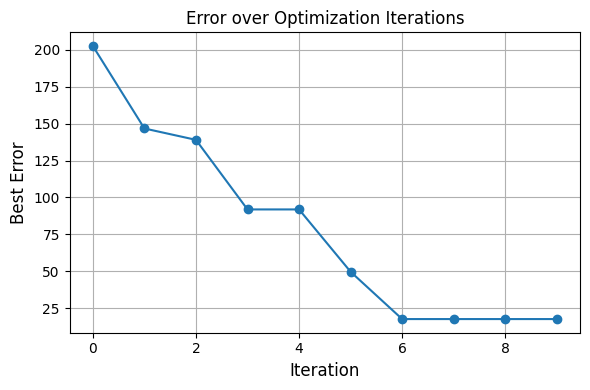

In [12]:
optimizer.plot_error_history()

In [13]:
optimizer.best_params

{'alpha': 0.9974750613372687,
 'beta': 0.10032389002466695,
 'delta': 0.07546928489370691,
 'gamma': 1.5050896523802313}

In [14]:
optimizer.best_error

0.984536939665863

In [15]:
history = optimizer.get_top_candidates_history()

# Example: print best candidate from each iteration
for i, candidates in enumerate(history):
    print(f"Iteration {i+1}: Best error = {candidates[0][1]:.4f}")

Iteration 1: Best error = 202.4287
Iteration 2: Best error = 146.6601
Iteration 3: Best error = 138.9719
Iteration 4: Best error = 91.9316
Iteration 5: Best error = 106.2031
Iteration 6: Best error = 49.7892
Iteration 7: Best error = 17.8100
Iteration 8: Best error = 18.9355
Iteration 9: Best error = 64.5878
Iteration 10: Best error = 67.5114


In [16]:
df = optimizer.get_top_candidates_table()
print(df)

    iteration  rank       error     alpha      beta     delta     gamma
0           1     1  202.428749  4.635283  0.548670  0.272194  3.750834
1           1     2  216.549683  3.948483  0.639474  0.266935  3.296262
2           1     3  223.666864  3.143117  0.334123  0.277048  2.619616
3           2     1  146.660120  6.541759  0.669410  0.176117  3.965542
4           2     2  151.858468  4.592497  0.524295  0.146545  3.973435
5           2     3  152.475245  3.694805  0.448981  0.095968  2.381629
6           3     1  138.971885  3.993469  0.532347  0.058605  1.390048
7           3     2  143.876217  5.957596  0.678494  0.129297  3.256364
8           3     3  144.798008  6.576679  0.705616  0.168484  4.360972
9           4     1   91.931551  1.696637  0.475640  0.068867  1.084132
10          4     2  142.461395  4.472557  0.412288  0.071161  1.382883
11          4     3  143.381335  4.072446  0.386802  0.097138  1.451908
12          5     1  106.203137  1.463124  0.445036  0.149201  1

In [17]:
best_params = optimizer.best_params


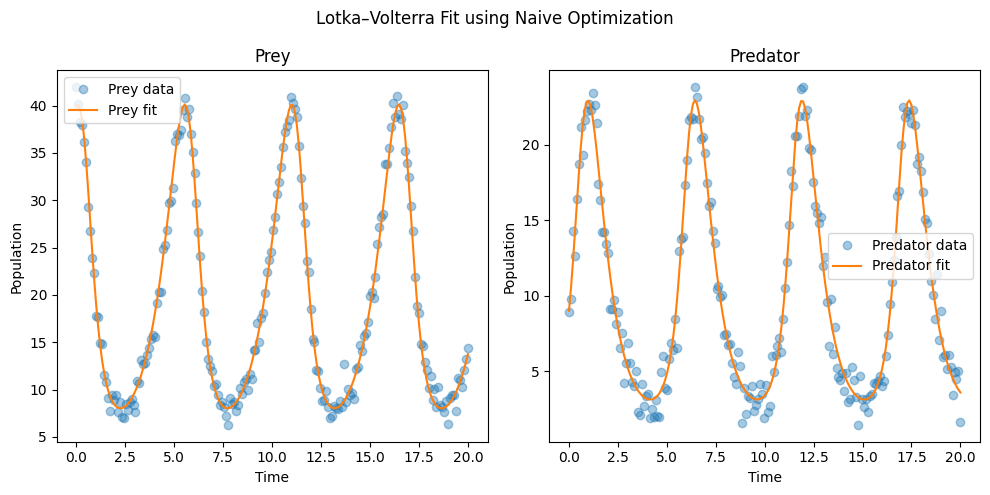

In [18]:
best_fit = simulate_model(best_params)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t, noisy_data[:, 0], 'o', alpha=0.4, label='Prey data')
plt.plot(t, best_fit[:, 0], label='Prey fit')
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Prey")

plt.subplot(1, 2, 2)
plt.plot(t, noisy_data[:, 1], 'o', alpha=0.4, label='Predator data')
plt.plot(t, best_fit[:, 1], label='Predator fit')
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Predator")

plt.suptitle("Lotka–Volterra Fit using Naive Optimization")
plt.tight_layout()
plt.show()

